In [238]:
import itertools
import os
import random as rd
import warnings
from sklearn.model_selection import KFold
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from pyriemann.estimation import Covariances
from pyriemann.utils import mean as riemann_mean
from pyriemann.utils import tangentspace
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_riemann
from pyriemann.utils.tangentspace import tangent_space, untangent_space
from data import *
from model import *

import random


class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y):
        self.X = X
        self.y = y
#         self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() 

    def __getitem__(self, index):
        return ((self.X[index,:]), (self.y[index]))
    



    
    
class Autoencoder_Linear_watch(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(200, 64), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(64, 16) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(64, 64),
#             nn.ReLU(),
            nn.Linear(64, 200)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
def train_autoencoder(model, data_loader, num_epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)
    for epoch in range(num_epochs):
        for (img, _) in data_loader:
            img = img.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def encode_data(model, data_loader):
    encoded_data = []
    for (img, _) in data_loader:
        batch_encoded = model.encoder(img.cuda()).cpu().detach().numpy()
        encoded_data.extend(batch_encoded)
    return np.array(encoded_data).reshape(-1, 16)

def train_regression(X_train, y_train, num_components=20):
    return PLSRegression(n_components=num_components).fit(X_train, y_train)

def train_multi_net(net, X_train, y_train, num_epochs=1000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
    inputs = Variable(torch.Tensor(X_train)).cuda()
    outputs = Variable(torch.Tensor(y_train)).cuda()
    for _ in range(num_epochs):
        prediction = net(inputs)
        loss = criterion(prediction, outputs) 
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
    return net


class model_multi(nn.Module):
    def __init__(self):
        super(model_multi, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
            nn.Linear(64, 16),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
    

class Autoencoder_Linear(nn.Module):
    def __init__(self, n_feat):
        super().__init__()        
        self.n_feat = n_feat

        self.encoder = nn.Sequential(
            nn.Linear(self.n_feat, 32), # (N, 784) -> (N, 128)
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(32, 16) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(32, self.n_feat)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
def process_tensors(X_tensor, X_tensor_old, qpfs_feat, qpfs_feat_num, train_index, last_index):
    if qpfs_feat_num != 0:
        for i in range(3):
            X_tensor[:, i, :qpfs_feat_num][::2] = X_tensor_old[:, i, qpfs_feat[i][:qpfs_feat_num]][::2]
    else:
        qpfs_feat_num = 200
        X_tensor = X_tensor_old

    tangent_space_data_phone_train, riemann_mean_phone_train = to_riemann_space(X_tensor[:train_index,:,:qpfs_feat_num][::2])
    tangent_space_data_watch_train, riemann_mean_watch_train = to_riemann_space(X_tensor_old[:train_index,:,:][1::2])
    cov_matrices_phone = Covariances().fit_transform(X_tensor[train_index:last_index,:,:qpfs_feat_num][::2])
    tangent_space_data_phone_test = tangent_space(cov_matrices_phone, riemann_mean_phone_train)

    cov_matrices_watch = Covariances().fit_transform(X_tensor_old[train_index:last_index,:,:][1::2])
    tangent_space_data_watch_test = tangent_space(cov_matrices_watch, riemann_mean_watch_train)
    
    
    reconstructed_data_train = untangent_space(tangent_space_data_watch_train, riemann_mean_watch_train)

    reconstructed_data_test = untangent_space(tangent_space_data_watch_test, riemann_mean_watch_train)

    return tangent_space_data_phone_train, riemann_mean_phone_train, tangent_space_data_watch_train, riemann_mean_watch_train, tangent_space_data_phone_test, tangent_space_data_watch_test, reconstructed_data_train, reconstructed_data_test



def main():
    iter_results = []
    for qpfs_feat_num in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 0]):
        correlations = []
        mses = []
        for cv_ind_ in range(5):
            

            tangent_space_data_phone_train,\
                riemann_mean_phone_train,\
                tangent_space_data_watch_train,\
                riemann_mean_watch_train,\
                tangent_space_data_phone_test,\
                tangent_space_data_watch_test, \
                reconstructed_data_train, \
                reconstructed_data_test = process_tensors(X_tensor[cv_ind[cv_ind_], :, :],
                                                                X_tensor_old[cv_ind[cv_ind_], :, :],
                                                                qpfs_feat,
                                                                qpfs_feat_num,
                                                                train_index,
                                                                last_index-2)

            BATCH_SIZE = 256
            N_EPOCHS = 20
            HIDDEN_SIZES =  [16, 32, 64]
            DROPOUT = 0.4
            LEARNING_RATE = 0.01

            data_loader_riemann = prepare_dataset(tangent_space_data_phone_train, tangent_space_data_watch_train, BATCH_SIZE)
            rieman_model = RiemannFullyConnected(n_features=6, hidden_sizes=HIDDEN_SIZES, dropout=DROPOUT).double().to(DEVICE)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(rieman_model.parameters(), lr=LEARNING_RATE)
            rieman_model = train_model(rieman_model, data_loader_riemann, N_EPOCHS, criterion, optimizer, DEVICE)
            output_data = eval_model(rieman_model, Variable(torch.tensor(tangent_space_data_phone_test)), DEVICE)


            N_EPOCHS = 20
            BATCH_SIZE = 256
            HIDDEN_SIZES = [512, 256, 512, 1024, 2048, 1024]

            DROPOUT = 0.5
            LEARNING_RATE = 1e-3
            train_loader = prepare_dataset(reconstructed_data_train, X_tensor_old[cv_ind[cv_ind_]][:train_index,:,:][1::2], BATCH_SIZE)
            model = CustomFullyConnected(n_ch=N_CH, n_features=N_FEATURES, hidden_sizes=HIDDEN_SIZES, dropout=DROPOUT).double().to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
            model = train_model(model, train_loader, N_EPOCHS, criterion, optimizer, DEVICE)
            output_data_series = eval_model(model, torch.tensor(untangent_space(output_data.cpu(), riemann_mean_watch_train)), DEVICE)

            average_correlation, average_mse = get_correlation_and_mse(X_tensor_old[cv_ind[cv_ind_]], output_data_series, train_index, last_index-2)
            print(qpfs_feat_num, average_correlation, average_mse)

            correlations.append(average_correlation)
            mses.append(average_mse)
        iter_results.append([qpfs_feat_num,correlations,mses])
        
    return iter_results
def cv_2d():

    iter_results = []
    for qpfs_feat_num in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 0]):
        correlations = []
        mses = []
        
        
            
        

        # Prepare data
        X_phone = torch.from_numpy(np.array(X_arr[smart_indexes[:-1]], dtype = np.float32))
        X_watch = torch.from_numpy(np.array(X_arr[watch_indexes[:-1]], dtype = np.float32))
        
        if qpfs_feat_num != 0:
                X_phone = X_phone[:,qpfs_2d_feat[:qpfs_feat_num]]
        else:
            qpfs_feat_num = 200
            
        model_phone = Autoencoder_Linear(n_feat=qpfs_feat_num).cuda()
        model_watch = Autoencoder_Linear_watch().cuda()
        net = model_multi().cuda()

        # Set up K-Fold cross validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        correlations_cv = []
        mses_cv = []
        # Iterate over each fold
        for train_index, test_index in kf.split(X_phone):
            # Split data into training and test sets
            X_phone_train, X_phone_test = X_phone[train_index], X_phone[test_index]
            X_watch_train, X_watch_test = X_watch[train_index], X_watch[test_index]
            print(X_phone_train.shape)
            # Prepare data loaders
            data_loader_phone_train = DataLoader(TimeseriesDataset(X_phone_train, np.arange((len(X_phone_train)))), batch_size=256, shuffle=True)
            data_loader_phone_test = DataLoader(TimeseriesDataset(X_phone_test, np.arange((len(X_phone_test)))), batch_size=256, shuffle=True)
            data_loader_watch_train = DataLoader(TimeseriesDataset(X_watch_train, np.arange((len(X_phone_train)))), batch_size=256, shuffle=True)
            data_loader_watch_test = DataLoader(TimeseriesDataset(X_watch_test, np.arange((len(X_phone_test)))), batch_size=256, shuffle=True)



            # Train Autoencoders
            model_phone = train_autoencoder(model_phone, data_loader_phone_train)
            model_watch = train_autoencoder(model_watch, data_loader_watch_train)

            # Encode data using trained Autoencoders
            encoded_from_phone_train = encode_data(model_phone, data_loader_phone_train)
            encoded_from_watch_train = encode_data(model_watch, data_loader_watch_train)

            # Train regression
            pls = train_regression(encoded_from_phone_train, encoded_from_watch_train)

            # Encode test data using trained Autoencoders
            encoded_from_phone_test = encode_data(model_phone, data_loader_phone_test)

            # Predict with regression
            y_pred = pls.predict(encoded_from_phone_test)

            # Train multi_net
            net = train_multi_net(net, encoded_from_phone_train, encoded_from_watch_train)
            net.eval()
            
#             output_data_series_net = eval_model(net, torch.tensor(encoded_from_phone_test), DEVICE)
            with torch.no_grad():
                output_data_series_net = net(Variable(torch.tensor(encoded_from_phone_test)).float().to(DEVICE))
            
            
            
     
            y_pred_orig_dim_pls = model_watch.decoder(torch.tensor(y_pred).float().cuda()).cpu().detach().numpy()


            # Convert y_pred back to original dimension
            y_pred_orig_dim = model_watch.decoder(output_data_series_net.cuda()).cpu().detach().numpy()
            
            correlations = []
            mses = []
            for target, prediction in zip(X_watch_test, y_pred_orig_dim):
                
#                 plt.plot(target)
#                 plt.plot(prediction)
                plt.show()
                correlation = np.corrcoef((target), (prediction))[0, 1]
                correlations.append((correlation))

                mse = mean_squared_error((target), (prediction), squared=False)
                mses.append(mse)
            average_correlation = np.mean(correlations)
            average_mse = np.mean(mses)
            
            correlations_cv.append(['NN',average_correlation])
            mses_cv.append(['NN', average_mse])
            
            
            correlations = []
            mses = []
            for target, prediction in zip(X_watch_test, y_pred_orig_dim_pls):
                correlation = np.corrcoef((target), (prediction))[0, 1]
                correlations.append((correlation))

                mse = mean_squared_error((target), (prediction), squared=False)
                mses.append(mse)
            average_correlation = np.mean(correlations)
            average_mse = np.mean(mses)
            
            correlations_cv.append(['pls',average_correlation])
            mses_cv.append(['pls', average_mse])
#             print (mses_cv, average_mse, average_correlation)
            
        print (qpfs_feat_num,correlations_cv,mses_cv)
        iter_results.append([qpfs_feat_num,correlations_cv,mses_cv])
    return iter_results
            


def to_riemann_space(data):
    cov_matrices = Covariances().fit_transform(data)
    riemann_mean = mean_riemann(cov_matrices)
    tangent_space_data = tangent_space(cov_matrices, riemann_mean)
    return tangent_space_data, riemann_mean
def to_time_series(tangent_space_data, riemann_mean):
    cov_matrices = untangent_space(tangent_space_data, riemann_mean)
    return cov_matrices



def train(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for batch_data, batch_targets in dataloader:
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        predictions = model(batch_data)
        loss = criterion(predictions, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

class CustomFullyConnected(nn.Module):
    def __init__(self, n_ch, n_features, hidden_sizes, dropout=None):
        super(CustomFullyConnected, self).__init__()
        layers = []
        input_size = n_ch * n_ch
        self.n_ch = n_ch
        self.n_features = n_features 
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=dropout))
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, n_ch * n_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.network(x)
        x = x.view(x.size(0), self.n_ch, self.n_features)
        return x

    
def is_unique(s):
    a = s.values # s.values (pandas<0.24)
    return ((a[0] == a) & (a[0]!=0)).all()


def collect_data(df, num_features, num_channels):
    """
    Collects data in tensor format from the given dataframe and normalizes it.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data.

    Returns:
    tuple: X_tensor (np.array), smart_indexes (list), watch_indexes (list)
    """

    
    X_tensor = np.zeros((int(len(df)/3),3, 200))
    index = 0
    to_select = []
    count = 0
    smart_indexes = []
    watch_indexes = []
    for user in tqdm(df.UserID.unique()):
        for activity in df.Activity.unique():


                if (df[(df.UserID==user) & (df.Activity==activity) ].shape[0] % 6==0) &(df[(df.UserID==user) & (df.Activity==activity) ].shape[0] // 6>=14):
                    for _ in range(int(df[(df.UserID==user) & (df.Activity==activity) ].shape[0] // 6)):

                            count += 1
                            
                            for device in [0,1]:
                                to_select.append([user,activity,device])
                                if device==0:
                                        smart_indexes.append(index)
                                else:
                                        watch_indexes.append(index)
                                
                                
                                for axi_ind, axis in enumerate(['x','y','z']):
                                        row = df[(df.Device==device)&(df.UserID==user) & (df.Activity==activity) &( 
                                            df.Axis==axis)  ]
                                        if row.shape==0:
                                            print(row.shape,index,axis, user, activity, device)


                                        X_tensor[index,axi_ind,:] = (row.values[0][:200])

                                index+=1



    return X_tensor, smart_indexes, watch_indexes







import torch 
import numpy as np
import sklearn.feature_selection as sklfs
import scipy as sc
import cvxpy as cvx
from sklearn.preprocessing import MinMaxScaler, StandardScaler



def get_corr_matrix(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = torch.unsqueeze(Y, dim  = 1)
    if len(X.shape) == 1:
        X = torch.unsqueeze(X, dim = 1)
    
    X_ = (X - X.mean(dim=0))
    Y_ = (Y - Y.mean(dim=0))
    
    idxs_nz_x = torch.where(torch.sum(X_ ** 2, dim = 0) != 0)[0]
    idxs_nz_y = torch.where(torch.sum(Y_ ** 2, dim = 0) != 0)[0]
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    corr = torch.ones((X.shape[1], Y.shape[1])) * fill
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = (Y_.T@ x) / torch.sqrt((x ** 2).sum() * (Y_ ** 2).sum(dim=0, keepdim=True))
    return corr


def shift_spectrum(Q, eps=0.):
    lamb_min = sc.linalg.eigh(Q)[0][0]
    if lamb_min < 0:
        Q = Q - (lamb_min - eps) * torch.eye(*Q.shape)
    return Q, lamb_min


class QPFS:
    def __init__(self, sim='corr', k  = 10):
        if sim not in ['corr', 'info']:
            raise ValueError('Similarity measure should be "corr" or "info"')
        self.sim = sim
        self.n_features = k
    
    def get_params(self, X, y):
        if self.sim == 'corr':
            self.Q = torch.abs(get_corr_matrix(X, fill=1))
            self.b = torch.unsqueeze(torch.sum(torch.abs(get_corr_matrix(X, y)), dim=1),1)
#             print (self.b)
        elif self.sim == 'info':
            self.Q = torch.ones([X.shape[1], X.shape[1]])
            self.b = torch.zeros((X.shape[1], 1))
            for j in range(self.n_features):
                self.Q[:, j] = torch.tensor(sklfs.mutual_info_regression((X), (X[:, j])))
            if len(y.shape) == 1:
                self.b = torch.unsqueeze(torch.tensor(sklfs.mutual_info_regression(X, y)), dim = 1)
            else:
                for y_ in y:
                    self.b += torch.tensor(sklfs.mutual_info_regression(X, y_))
        self.n = self.Q.shape[0]
    
    def get_alpha(self):
        return self.Q.mean() / (self.Q.mean() + self.b.mean())

    def fit(self, X, y):
        self.get_params(X, y)
        alpha = self.get_alpha()
        self.solve_problem(alpha)
    
    def solve_problem(self, alpha):
        
        c = torch.ones((self.n, 1))
        
        Q, _ = shift_spectrum(self.Q)
        
        x = cvx.Variable(self.n)
        objective = cvx.Minimize((1 - alpha) * cvx.quad_form(x, Q) - 
                                 alpha * self.b.T * x)
        constraints = [x >= 0, c.T * x == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = torch.tensor(x.value).flatten()
        
    def get_topk_indices(self):
        return torch.argsort(self.score).flip(dims = [0])[:self.n_features]
    
    


                            
import torch.nn as nn

class RiemannFullyConnected(nn.Module):
    def __init__(self, n_features, hidden_sizes, dropout=None):
        super().__init__()
        layers = []
        input_size = n_features
        self.n_features = n_features
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=dropout))
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, n_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.network(x)
        x = x.view(x.size(0), self.n_features)
        return x

    
    





def prepare_dataset(reconstructed_data_train, X_tensor, BATCH_SIZE):
    """
    Prepare dataset and dataloader for training.
    
    Parameters:
    reconstructed_data_train (np.array): The training data reconstructed by the model.
    X_tensor (np.array): The tensor data.
    
    Returns:
    DataLoader: DataLoader for the training data.
    """
    dataset = TensorDataset(torch.tensor(reconstructed_data_train).double(), torch.tensor(X_tensor).double())
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader
    

    
from itertools import product
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tenalg import mode_dot, multi_mode_dot, kronecker
import numpy as np
import torch

from sklearn.model_selection import KFold


def plot_data(prediction_data, target_data):
    """
    Plot prediction data against the target data.

    Parameters:
    prediction_data (np.array): The data predicted by the model.
    target_data (np.array): The target data.

    Returns:
    None
    """
    
    
    axis = ['x', 'y', 'z']
    for AXIS in range(3):
        plt.figure(figsize=(10,5))
        plt.plot(min_max_normalize_data(prediction_data[AXIS]), label='prediction')
        plt.plot(min_max_normalize_data(target_data[AXIS]), label='target')
        plt.legend()
        plt.title(axis[AXIS])
        plt.ylabel('Signal')
        plt.xlabel('T')
        plt.show()
# model = QPFS(k = 100)
# model.fit(torch.tensor(X_tensor[:10012*2,2,:][::2]),torch.tensor(X_tensor[:10012*2,2,:][1::2]))
# model.get_topk_indices()
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



def train_model(model, train_loader, n_epochs, criterion, optimizer, device):
    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
    model.eval()
    return model

def eval_model(model, input_data, device):
    with torch.no_grad():
        output_data = model(Variable(input_data).double().to(device))
    return output_data

def get_correlation_and_mse(X_tensor_old, output_data_series, train_index, last_index):
    correlations = []
    mses = []
    for target, prediction in zip(X_tensor_old[train_index:last_index,:,:][1::2], output_data_series.cpu().numpy()):
        correlation = np.corrcoef(target, prediction)[0, 1]
        correlations.append(correlation)

        mse = mean_squared_error(target, prediction, squared=False)
        mses.append(mse)
    average_correlation = np.mean(correlations)
    average_mse = np.mean(mses)
    return average_correlation, average_mse


In [2]:
df = np.load('xyz_acc.npy', allow_pickle =True) #np.load('series.npy', allow_pickle=True)
df = pd.DataFrame(df, columns = [str(i) for i in np.arange(2950)]+ ['Axis','UserID', 'Activity', 'Device'])
df.drop(df[(df.Device==1) & (df.UserID==1607) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1609) & (df.Activity=='B')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1616) & (df.Activity=='F')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1637) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1639) & (df.Activity=='L')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1643) & (df.Activity=='I')].index[0], inplace = True)

In [3]:
# Создаем список для хранения новых строк
new_rows = []

for i, row in tqdm(df.iterrows()):
    for j in range(14):  # 2800 / 200 = 14
        # Разбиваем строку на 200-точечные фрагменты и сохраняем их как новые строки
        new_row = row[j*200:(j+1)*200].tolist()
        # Добавляем информацию из столбцов 'Axis','UserID', 'Activity', 'Device'
        new_row.extend(row[['Axis', 'UserID', 'Activity', 'Device']])
        new_rows.append(new_row)

# Преобразуем список списков в DataFrame
new_df = pd.DataFrame(new_rows, columns=[f'val_{i}' for i in range(200)] + ['Axis', 'UserID', 'Activity', 'Device'])


5460it [00:38, 143.42it/s]


In [4]:
df = pd.DataFrame(new_rows, columns=[f'val_{i}' for i in range(200)] + ['Axis', 'UserID', 'Activity', 'Device'])



scaler = MinMaxScaler()

df[df.columns[0:200]] = scaler.fit_transform(df[df.columns[0:200]])

In [5]:
N_FEATURES = 200
N_CH = 3


In [6]:
X_tensor, smart_indexes, watch_indexes = collect_data(df, N_FEATURES, N_CH)


100%|██████████| 51/51 [14:50<00:00, 17.47s/it]


In [9]:


X_arr = np.sqrt(np.sum(np.square(X_tensor), axis=1))
    

In [144]:
qpfs_feat = [[ 97,   0,   4,   7,   8, 166,  16,  99, 121,  14,   9,  71,  57,  80,
         32,  77,  58,  44,  49, 136,  83,  13,  64, 164,  69,  93,  94,  72,
         12,  70,  34,  41,  39,  20, 132,  45,  78,  48, 115,  92,  65,  11,
         75, 144,  55,  15,  25,  89,  26,  96, 157,  76,  46,  60, 103,  40,
         68,  90,  28,  43,  95,  10,  30,  91,  98,  81,  61, 134,  63,  53,
         18,  73,  50,  84,  31, 150,  17,  52, 124, 158,  19, 122,   2, 113,
         37, 117, 105, 142, 131, 120,  66, 143, 118, 152, 128,  85,  33, 106,
          5,  23,  87, 133, 159,   1, 100, 151, 137, 112,  24,  54,  36, 119,
         56,  21, 165,  62, 194, 148, 123, 101, 189, 190, 145,  88, 102, 188,
        154, 126, 195, 183, 149, 153, 193, 184,  79, 129, 107, 146,  22,  86,
          6, 156, 147,  42, 141, 182, 196, 155, 192, 174],
[ 16,   1, 149, 131, 117,   2, 198,   5, 122,   7,  97,  89,  80,  42,
         40,  66,  24,  43,  17,  75,  12,  79, 120,  72,  33, 129, 123,  60,
         67,  51,  11,  15, 103,  14,  69,  25,  87,  36,  85,  68,  30,  35,
         95,  83,  70, 121, 127,  37,  74,  73,  23,  81,  21,  98,  65,  18,
        126, 108,  86,  52,  64,   9,  99, 124,  45,  34,  88,  90, 112, 119,
         92, 101,   8,  19,  49,  13,  58,  96,  91,   6,  62,  31, 100,  94,
         46,   4, 110, 192, 136,  76, 190,  41,  82,  93, 151, 135,  22, 102,
        155, 138, 133, 139, 153, 150, 193, 137, 148,  50,  48, 159, 130, 134,
        166, 172, 106, 128, 189, 156,  10, 140, 171, 195, 196, 114,  61, 141,
        152, 178, 158, 147, 142, 160, 181, 162, 184, 199, 191, 143, 170, 185,
        157, 144, 177,  63, 187,  59, 173, 161, 154, 167],

[ 16,   1, 131, 117,   2,   5,   7, 122,  97,  24, 118,  10,   0,  67,
         76,  29,  17,  27,  52,  56,  83,  96,  51,  11,  77,  18,  31,  61,
         15,  86,  92,  33,  42,  68,  49,  20,  19,  41, 114,  79,  30, 101,
         82,  70,  85,  21, 129,  93, 107,   4,  40,  66, 100,  25,  69,  28,
         78,  12,  45,  32,  98,   8,  23,  81, 128, 111,  57, 110,  13,  58,
         99, 119,  75,  94,  46,  80,  95,  64,  35,  43, 106,  59, 123,  53,
         89,  73,  26,  91, 130,  48,  50,  22, 102,  60,  14, 155,   3,  90,
         54,  84,  47, 154,  87, 104, 157, 186,  72, 136, 197, 144, 161,  37,
         74, 137, 121,  39, 191, 156, 166, 181, 177, 162, 176, 198, 159, 171,
        148,  36, 112, 158, 116, 183,  34,  88,   6, 151, 179, 173, 194, 132,
        150, 126, 133, 109, 145, 141, 160,  63, 153, 140]]




In [ ]:



last_index = np.nonzero(X_tensor)[0][-1] if np.nonzero(X_tensor)[0][-1] % 2==0 else np.nonzero(X_tensor)[0][-1]-1
train_index = int(last_index*0.8) if int(last_index*0.8) % 2==0 else int(last_index*0.8)-1

X_tensor = X_tensor[:last_index]
X_tensor_old = X_tensor.copy()

In [119]:
X_arr = np.sqrt(np.sum(np.square(X_tensor_old), axis=1))
X_arr = scaler.fit_transform(X_arr)

X_arr_old = X_arr.copy()

In [154]:


qpfs_2d_feat = [ 57,  17,   0,  97,  41,  19, 149, 138, 157,  59, 118,  72, 156, 141,
         73, 133,  40, 150, 134, 171, 139,  58, 140, 119, 155,  55,  16,   6,
        187,  39, 148, 117, 170,  60, 137,  25,  20, 135,  56,  74,  98, 125,
        172,  75,  42,  43, 152,  18, 136, 158,  15,   1,  96,  10,  95,  52,
        147,  79, 151,  63, 109, 186, 120,  48,  26,  99,   7, 126, 177,   2,
         47,  34, 130,  76,  78, 142,  87,  38, 110,  77,  33,  44,  35,  51,
         11,  62,  36, 127, 132,  83,  88, 116, 111,  32,  54,  80,  68,  37,
        178,   4, 191, 185,  27, 192, 146, 129, 199,  45, 161, 176, 100,  14,
          9,  23, 101,  31,  46,   3, 115,  67, 102, 162,  85,  70,  94, 197,
        179,  28,  49, 193,  66,  71, 175, 182, 169, 166,   5,  29,  22, 160,
        167, 103, 124,  53,  61, 198, 108,  30,  84, 173]



exp_2d_res = cv_2d()
      

  0%|          | 0/13 [00:00<?, ?it/s]

torch.Size([10168, 10])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 10])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 10])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 10])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 10])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
  8%|▊         | 1/13 [02:52<34:30, 172.56s/it]

10 [['NN', 0.7432780687222434], ['pls', 0.743446164981386], ['NN', 0.7447139398550391], ['pls', 0.7446681736996503], ['NN', 0.7570515935716022], ['pls', 0.7570269996296258], ['NN', 0.7548982716735326], ['pls', 0.7547979680075507], ['NN', 0.7462793591153549], ['pls', 0.7462566211118744]] [['NN', 0.10534315], ['pls', 0.105219856], ['NN', 0.10512679], ['pls', 0.10508168], ['NN', 0.1023919], ['pls', 0.10224325], ['NN', 0.10422647], ['pls', 0.10409954], ['NN', 0.104790844], ['pls', 0.10488618]]
torch.Size([10168, 20])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 20])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 20])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 20])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 20])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 15%|█▌        | 2/13 [05:46<31:49, 173.61s/it]

20 [['NN', 0.741756906846348], ['pls', 0.7416517278648745], ['NN', 0.74536197842327], ['pls', 0.7454407233648035], ['NN', 0.7569901991917986], ['pls', 0.7569517007082981], ['NN', 0.7540657114855094], ['pls', 0.7540716633857063], ['NN', 0.7455331267127512], ['pls', 0.7456838932887728]] [['NN', 0.10539754], ['pls', 0.105311185], ['NN', 0.10510729], ['pls', 0.10498066], ['NN', 0.102308966], ['pls', 0.102220714], ['NN', 0.1043732], ['pls', 0.104313545], ['NN', 0.105025515], ['pls', 0.10499728]]
torch.Size([10168, 30])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 30])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 30])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 30])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 30])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 23%|██▎       | 3/13 [08:46<29:25, 176.55s/it]

30 [['NN', 0.7441421582523757], ['pls', 0.7440903518705271], ['NN', 0.7457413640539037], ['pls', 0.7459794586842736], ['NN', 0.7574766617247384], ['pls', 0.7575123347135239], ['NN', 0.7546823323806368], ['pls', 0.7549529999708385], ['NN', 0.7452674846297368], ['pls', 0.7459310434416873]] [['NN', 0.10511677], ['pls', 0.10512844], ['NN', 0.10522694], ['pls', 0.10499908], ['NN', 0.10247013], ['pls', 0.1021], ['NN', 0.10456895], ['pls', 0.1042938], ['NN', 0.10524101], ['pls', 0.10500798]]
torch.Size([10168, 40])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 40])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 40])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 40])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 40])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 31%|███       | 4/13 [11:44<26:31, 176.80s/it]

40 [['NN', 0.744261326533643], ['pls', 0.7442087723489779], ['NN', 0.7451447340988013], ['pls', 0.744911624378233], ['NN', 0.7567374936763809], ['pls', 0.7566444826838987], ['NN', 0.754396233331889], ['pls', 0.7545119236830226], ['NN', 0.7455093245943537], ['pls', 0.7455277601627228]] [['NN', 0.10514253], ['pls', 0.10523966], ['NN', 0.10496169], ['pls', 0.10503979], ['NN', 0.102310814], ['pls', 0.10222049], ['NN', 0.10440089], ['pls', 0.104299895], ['NN', 0.10502766], ['pls', 0.104998395]]
torch.Size([10168, 50])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 50])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 50])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 50])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 50])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 38%|███▊      | 5/13 [14:36<23:22, 175.25s/it]

50 [['NN', 0.744225283454991], ['pls', 0.7440526192333556], ['NN', 0.745188424095966], ['pls', 0.745188380688366], ['NN', 0.7564227386800304], ['pls', 0.7565550499025425], ['NN', 0.7545415978862549], ['pls', 0.7548425046511289], ['NN', 0.7453042080716895], ['pls', 0.7457722589230601]] [['NN', 0.1049989], ['pls', 0.10517303], ['NN', 0.105201945], ['pls', 0.105049424], ['NN', 0.10238614], ['pls', 0.10230018], ['NN', 0.104422554], ['pls', 0.10420325], ['NN', 0.1053563], ['pls', 0.10496181]]
torch.Size([10168, 60])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 60])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 60])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 60])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 60])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 46%|████▌     | 6/13 [17:33<20:31, 175.95s/it]

60 [['NN', 0.7436483107572767], ['pls', 0.7439946488913652], ['NN', 0.7454456393324067], ['pls', 0.7453818785856107], ['NN', 0.7567980632303165], ['pls', 0.7569013682039264], ['NN', 0.7545428757101306], ['pls', 0.7548629949585688], ['NN', 0.7448572450752818], ['pls', 0.7450964500374343]] [['NN', 0.10515789], ['pls', 0.105074905], ['NN', 0.10516004], ['pls', 0.105112806], ['NN', 0.102384456], ['pls', 0.1022373], ['NN', 0.10452196], ['pls', 0.10422322], ['NN', 0.10521428], ['pls', 0.105001636]]
torch.Size([10168, 70])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 70])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 70])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 70])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 70])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 80])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 80])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 62%|██████▏   | 8/13 [23:21<14:34, 174.84s/it]

80 [['NN', 0.7441240970009682], ['pls', 0.7440588220682575], ['NN', 0.7447620374828748], ['pls', 0.7446780840856315], ['NN', 0.7563958954516388], ['pls', 0.7565280970223746], ['NN', 0.754561101507628], ['pls', 0.7547659695264148], ['NN', 0.7460789166807033], ['pls', 0.7463370156799852]] [['NN', 0.10525736], ['pls', 0.10514436], ['NN', 0.10493662], ['pls', 0.10504507], ['NN', 0.10240484], ['pls', 0.1022545], ['NN', 0.104487844], ['pls', 0.10430423], ['NN', 0.10501796], ['pls', 0.105006725]]
torch.Size([10168, 90])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 90])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 90])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 90])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 90])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 69%|██████▉   | 9/13 [26:16<11:38, 174.69s/it]

90 [['NN', 0.7439655803768379], ['pls', 0.743824354152061], ['NN', 0.7439769296023461], ['pls', 0.7439962515007008], ['NN', 0.7571775284512771], ['pls', 0.7572885019881346], ['NN', 0.7546918866970533], ['pls', 0.7547876920980751], ['NN', 0.7449938227091054], ['pls', 0.7453080848178074]] [['NN', 0.1051746], ['pls', 0.10521806], ['NN', 0.10520909], ['pls', 0.10517588], ['NN', 0.10215207], ['pls', 0.10223593], ['NN', 0.10430433], ['pls', 0.104195476], ['NN', 0.105300665], ['pls', 0.105067216]]
torch.Size([10168, 100])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 100])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 100])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 100])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 100])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 77%|███████▋  | 10/13 [29:11<08:44, 174.91s/it]

100 [['NN', 0.7441513689983597], ['pls', 0.7441228866984839], ['NN', 0.7449767624879398], ['pls', 0.7450542494047329], ['NN', 0.7564820402480993], ['pls', 0.7566231873826084], ['NN', 0.7546937743575481], ['pls', 0.7551370727195764], ['NN', 0.7452078738856879], ['pls', 0.7461017312489304]] [['NN', 0.105289266], ['pls', 0.105118155], ['NN', 0.10524197], ['pls', 0.10500227], ['NN', 0.10232192], ['pls', 0.10224481], ['NN', 0.10471813], ['pls', 0.10426786], ['NN', 0.10518219], ['pls', 0.10483723]]
torch.Size([10168, 120])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 120])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 120])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 120])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 120])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 85%|████████▍ | 11/13 [32:06<05:49, 174.76s/it]

120 [['NN', 0.7438258908025225], ['pls', 0.7438133453634996], ['NN', 0.7456570899214238], ['pls', 0.7456832026842524], ['NN', 0.7561583904966037], ['pls', 0.7560379435996558], ['NN', 0.7544003399535674], ['pls', 0.754806526378647], ['NN', 0.7456593186443148], ['pls', 0.7457796576226974]] [['NN', 0.10516552], ['pls', 0.10514664], ['NN', 0.10498842], ['pls', 0.105049424], ['NN', 0.10251617], ['pls', 0.10234964], ['NN', 0.104446806], ['pls', 0.10429698], ['NN', 0.105186746], ['pls', 0.10501189]]
torch.Size([10168, 150])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 150])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 150])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 150])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 150])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
 92%|█████████▏| 12/13 [35:04<02:55, 175.80s/it]

150 [['NN', 0.7431253067440641], ['pls', 0.7431093117041774], ['NN', 0.745119712992259], ['pls', 0.7451895902486813], ['NN', 0.7567854489250333], ['pls', 0.756833097366416], ['NN', 0.7546596831096379], ['pls', 0.7549864031432977], ['NN', 0.7446791653560088], ['pls', 0.7450339097681135]] [['NN', 0.10519085], ['pls', 0.105095364], ['NN', 0.105132766], ['pls', 0.10495343], ['NN', 0.1023501], ['pls', 0.102235064], ['NN', 0.104251266], ['pls', 0.10421081], ['NN', 0.105306104], ['pls', 0.105029255]]
torch.Size([10168, 200])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 200])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 200])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 200])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


torch.Size([10169, 200])
40
40


/home/rosafiullin/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
100%|██████████| 13/13 [38:00<00:00, 175.44s/it]

200 [['NN', 0.7444970068339098], ['pls', 0.7444791212103737], ['NN', 0.7450293486786338], ['pls', 0.7450509632540646], ['NN', 0.7567254783648054], ['pls', 0.7570128104235716], ['NN', 0.7538040828755461], ['pls', 0.7542557827718749], ['NN', 0.7455467793274206], ['pls', 0.7458952942510608]] [['NN', 0.10515196], ['pls', 0.10511889], ['NN', 0.105089165], ['pls', 0.10505523], ['NN', 0.10237581], ['pls', 0.10218613], ['NN', 0.10454704], ['pls', 0.104338504], ['NN', 0.10478713], ['pls', 0.10487775]]


In [283]:

index_shuf = np.array(range(len(X_tensor)))

cv_ind = []
for i in range(5):
    random.shuffle(index_shuf)
    cv_ind.append(index_shuf.copy())

In [285]:
# X_tensor_old[cv_ind[1], :, :] - X_tensor_old[cv_ind[4], :, :]

In [288]:

    

exp_res = main()


  0%|          | 0/13 [00:00<?, ?it/s]

10 0.8469716576422524 0.05684446307121684
10 0.8506146053155769 0.05542579763271879
10 0.8511001917905794 0.05458492891171582
10 0.8431334587036702 0.05317441280573903


  8%|▊         | 1/13 [02:23<28:41, 143.49s/it]

10 0.8451502410765412 0.0540948733934586
20 0.8469716576422524 0.062338283049679165
20 0.8506146053155769 0.05436283133780771
20 0.8511001917905794 0.054410097022156254
20 0.8431334587036702 0.05479628302814537


 15%|█▌        | 2/13 [04:47<26:23, 143.94s/it]

20 0.8451502410765412 0.053626940316082145
30 0.8469716576422524 0.0533447799807028
30 0.8506146053155769 0.05360892271870603
30 0.8511001917905794 0.05335395123517195
30 0.8431334587036702 0.05523671393047425


 23%|██▎       | 3/13 [07:09<23:49, 142.93s/it]

30 0.8451502410765412 0.05393047111191946
40 0.8469716576422524 0.05604503204199155
40 0.8506146053155769 0.053654175072638054
40 0.8511001917905794 0.05390420859752587
40 0.8431334587036702 0.053843896480977094


 31%|███       | 4/13 [09:34<21:34, 143.79s/it]

40 0.8451502410765412 0.05594843086359522
50 0.8469716576422524 0.053829597036194526
50 0.8506146053155769 0.054384846033046
50 0.8511001917905794 0.05728508265214955
50 0.8431334587036702 0.06926298826372053


 38%|███▊      | 5/13 [11:56<19:04, 143.04s/it]

50 0.8451502410765412 0.0545899903764682
60 0.8469716576422524 0.05535652376708077
60 0.8506146053155769 0.056621190904374896
60 0.8511001917905794 0.05471896981185276
60 0.8431334587036702 0.05347862966780868


 46%|████▌     | 6/13 [14:18<16:39, 142.74s/it]

60 0.8451502410765412 0.05417732408754381
70 0.8469716576422524 0.06250058080739969
70 0.8506146053155769 0.05458940010751874
70 0.8511001917905794 0.053721550680868396
70 0.8431334587036702 0.05584199111477909


 54%|█████▍    | 7/13 [16:40<14:14, 142.42s/it]

70 0.8451502410765412 0.05422914341702218
80 0.8469716576422524 0.05439863915710445
80 0.8506146053155769 0.05574185420808914
80 0.8511001917905794 0.058262867603610276
80 0.8431334587036702 0.053498341152910536


 62%|██████▏   | 8/13 [19:02<11:51, 142.33s/it]

80 0.8451502410765412 0.05422525947237557
90 0.8469716576422524 0.05368177908343856
90 0.8506146053155769 0.05444601694090943
90 0.8511001917905794 0.060837203637937445
90 0.8431334587036702 0.05484870153072661


 69%|██████▉   | 9/13 [21:24<09:28, 142.16s/it]

90 0.8451502410765412 0.07119594384532248
100 0.8469716576422524 0.05425605826941063
100 0.8506146053155769 0.05583228699181051
100 0.8511001917905794 0.05652910920983155
100 0.8431334587036702 0.05327825973402597


 77%|███████▋  | 10/13 [23:49<07:09, 143.09s/it]

100 0.8451502410765412 0.05365557421840696
120 0.8469716576422524 0.056588679446054724
120 0.8506146053155769 0.0537247426155975
120 0.8511001917905794 0.05461317671178508
120 0.8431334587036702 0.05336401255420581


 85%|████████▍ | 11/13 [26:11<04:45, 142.70s/it]

120 0.8451502410765412 0.055909267255517495
150 0.8469716576422524 0.05395795748770667
150 0.8506146053155769 0.06409272345347075
150 0.8511001917905794 0.055353511113768815
150 0.8431334587036702 0.060126066665685145


 92%|█████████▏| 12/13 [28:34<02:22, 142.77s/it]

150 0.8451502410765412 0.05679629347142236
0 0.8469716576422524 0.05380080889859412
0 0.8506146053155769 0.05406988661485846
0 0.8511001917905794 0.05551911906780227
0 0.8431334587036702 0.0538866957489619


100%|██████████| 13/13 [30:56<00:00, 142.82s/it]

0 0.8451502410765412 0.0543367067633122


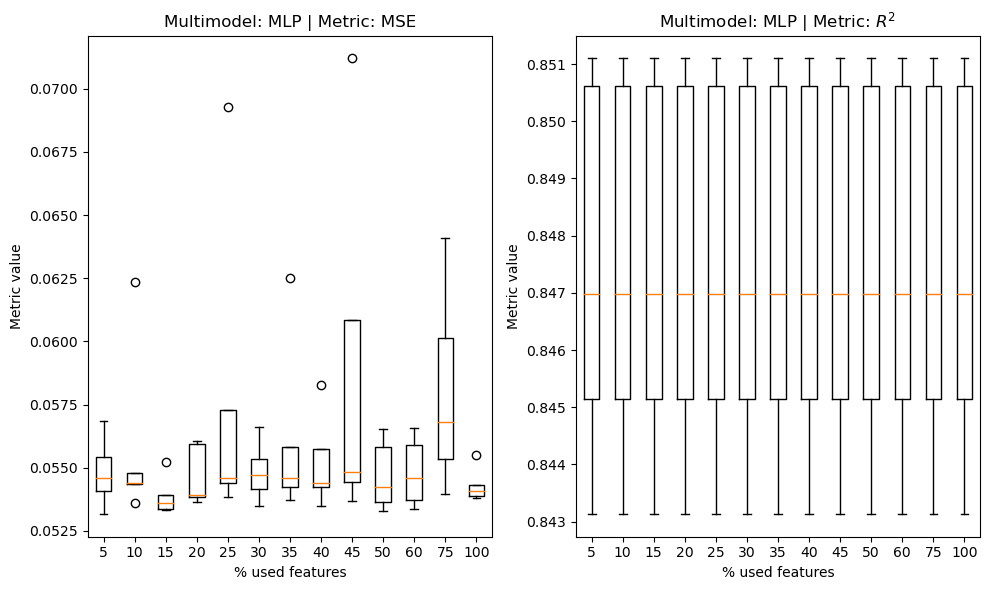

In [289]:

# Prepare data for boxplots
mse_data = [res[2] for res in exp_res]
corr_data = [res[1] for res in exp_res]

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.flatten()

# Plot boxplots for MSE
axs[0].boxplot(mse_data)
axs[0].set_title('Multimodel: MLP | Metric: MSE')
axs[0].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[0].set_xlabel('% used features')
axs[0].set_ylabel('Metric value')

# Plot boxplots for correlation
axs[1].boxplot(corr_data)
axs[1].set_title('Multimodel: MLP | Metric: $R^2$')
# axs[1].set_ylim([0.84954, 0.84955])
axs[1].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[1].set_xlabel('% used features')
axs[1].set_ylabel('Metric value')
fig.tight_layout()
plt.show()

/tmp/ipykernel_25034/1602525953.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  corr_row = np.array(np.array(exp_2d_res)[i][1])
/tmp/ipykernel_25034/1602525953.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mse_row = np.array(np.array(exp_2d_res)[i][2])
/tmp/ipykernel_25034/1602525953.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating t

10 pls MSE 0.10430610119999999 0.0011019060147243786
10 NN MSE 0.10437583080000001 0.0010611476974194316
10 pls corr 0.7492391854860175 0.005565950733184491
10 NN corr 0.7492442465875545 0.005618401582945051
20 pls MSE 0.10436467680000001 0.0011202402271615482
20 NN MSE 0.1044425022 0.001118098694664903
20 pls corr 0.748759941722491 0.005767586861543091
20 NN corr 0.7487415845319354 0.005777328673763296
30 pls MSE 0.10430586 0.001141589076892383
30 NN MSE 0.10452476 0.0010564093759523315
30 pls corr 0.74969323773617 0.005443196984965246
30 NN corr 0.7494620002082782 0.005499535980077503
40 pls MSE 0.10435964599999999 0.0011157579809501696
40 NN MSE 0.1043687168 0.001060246129376079
40 pls corr 0.749160912651371 0.005299378848529111
40 NN corr 0.7492098224470136 0.0052587247778364534
50 pls MSE 0.1043375388 0.0010736298222524178
50 NN MSE 0.1044731678 0.001090475110285128
50 pls corr 0.7492821626796906 0.005296015321467045
50 NN corr 0.7491364504377863 0.005228731585573395
60 pls MSE 0.

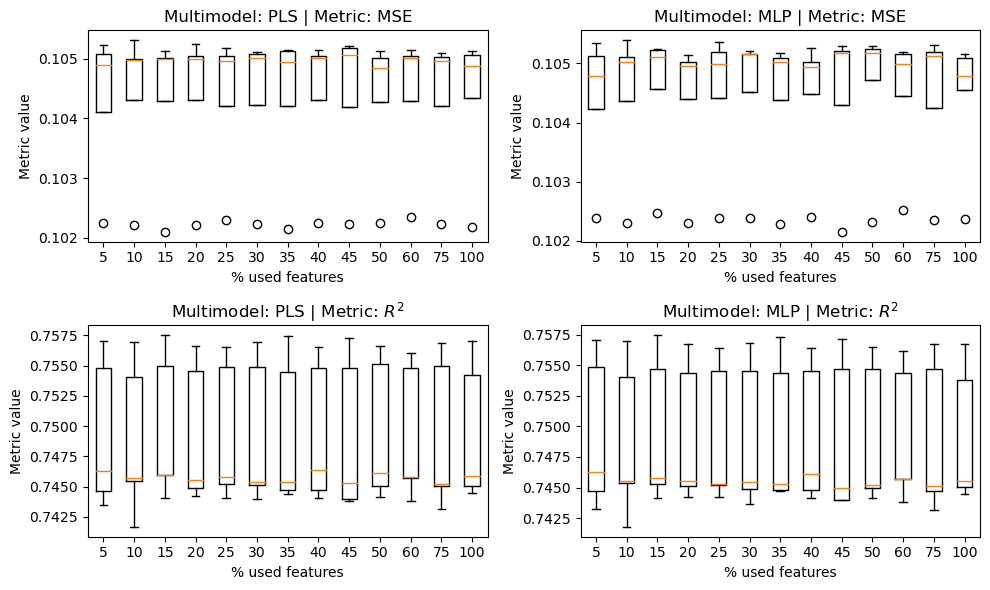

In [223]:
pls_mse_mean, pls_mse_std, pls_corr_mean, pls_corr_std, nn_mse_mean, nn_mse_std, nn_corr_mean, nn_corr_std = [],[],[],[],[],[],[],[]
for i in range(len(exp_2d_res)):

    corr_row = np.array(np.array(exp_2d_res)[i][1])
    corr_vals_nn = corr_row[corr_row[:,0]=='NN'][:,1].astype(float)
    corr_vals_pls = corr_row[corr_row[:,0]=='pls'][:,1].astype(float)
    
    mse_row = np.array(np.array(exp_2d_res)[i][2])
    mse_vals_nn = mse_row[mse_row[:,0]=='NN'][:,1].astype(float)
    mse_vals_pls = mse_row[mse_row[:,0]=='pls'][:,1].astype(float)
    
    
    print(np.array(exp_2d_res)[i][0], 'pls','MSE', np.mean(mse_vals_pls), np.std(mse_vals_pls))
    print(np.array(exp_2d_res)[i][0], 'NN','MSE', np.mean(mse_vals_nn), np.std(mse_vals_nn))
    
    print(np.array(exp_2d_res)[i][0], 'pls','corr', np.mean(corr_vals_pls), np.std(corr_vals_pls))
    print(np.array(exp_2d_res)[i][0], 'NN','corr', np.mean(corr_vals_nn), np.std(corr_vals_nn))
    
    
        # plot
        
    pls_mse_mean.append(np.mean(mse_vals_pls))
    pls_mse_std.append(np.std(mse_vals_pls))
    pls_corr_mean.append(np.mean(corr_vals_pls))
    pls_corr_std.append(np.std(corr_vals_pls))
    nn_mse_mean.append(np.mean(mse_vals_nn))
    nn_mse_std.append(np.std(mse_vals_nn))
    nn_corr_mean.append(np.mean(corr_vals_nn))
    nn_corr_std.append(np.std(corr_vals_nn))

    
# Prepare data for boxplots
pls_mse_data = [np.array(np.array(res)[2])[np.array(np.array(res)[2])[:,0]=='pls'][:,1].astype(float) for res in exp_2d_res]

nn_mse_data = [np.array(np.array(res)[2])[np.array(np.array(res)[2])[:,0]=='NN'][:,1].astype(float) for res in exp_2d_res]
pls_corr_data = [np.array(np.array(res)[1])[np.array(np.array(res)[2])[:,0]=='pls'][:,1].astype(float) for res in exp_2d_res]
nn_corr_data = [np.array(np.array(res)[1])[np.array(np.array(res)[2])[:,0]=='NN'][:,1].astype(float) for res in exp_2d_res]


fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

# Plot boxplots for PLS MSE
axs[0].boxplot(pls_mse_data)
axs[0].set_title('Multimodel: PLS | Metric: MSE')
axs[0].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[0].set_xlabel('% used features')
axs[0].set_ylabel('Metric value')

# Plot boxplots for NN MSE
axs[1].boxplot(nn_mse_data)
axs[1].set_title('Multimodel: MLP | Metric: MSE')
axs[1].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[1].set_xlabel('% used features')
axs[1].set_ylabel('Metric value')

# Plot boxplots for PLS correlation
axs[2].boxplot(pls_corr_data)
axs[2].set_title('Multimodel: PLS | Metric: $R^2$')
axs[2].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[2].set_xlabel('% used features')
axs[2].set_ylabel('Metric value')

# Plot boxplots for NN correlation
axs[3].boxplot(nn_corr_data)
axs[3].set_title('Multimodel: MLP | Metric: $R^2$')
axs[3].set_xticklabels(np.array(np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200])/2).astype(int))
axs[3].set_xlabel('% used features')
axs[3].set_ylabel('Metric value')

fig.tight_layout()
plt.show()



In [158]:
import torch 
import numpy as np
import sklearn.feature_selection as sklfs
import scipy as sc
import cvxpy as cvx
from sklearn.preprocessing import MinMaxScaler, StandardScaler



def get_corr_matrix(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = torch.unsqueeze(Y, dim  = 1)
    if len(X.shape) == 1:
        X = torch.unsqueeze(X, dim = 1)
    
    X_ = (X - X.mean(dim=0))
    Y_ = (Y - Y.mean(dim=0))
    
    idxs_nz_x = torch.where(torch.sum(X_ ** 2, dim = 0) != 0)[0]
    idxs_nz_y = torch.where(torch.sum(Y_ ** 2, dim = 0) != 0)[0]
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    corr = torch.ones((X.shape[1], Y.shape[1])) * fill
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = (Y_.T@ x) / torch.sqrt((x ** 2).sum() * (Y_ ** 2).sum(dim=0, keepdim=True))
    return corr


def shift_spectrum(Q, eps=0.):
    lamb_min = sc.linalg.eigh(Q)[0][0]
    if lamb_min < 0:
        Q = Q - (lamb_min - eps) * torch.eye(*Q.shape)
    return Q, lamb_min


class QPFS:
    def __init__(self, sim='corr', k  = 10):
        if sim not in ['corr', 'info']:
            raise ValueError('Similarity measure should be "corr" or "info"')
        self.sim = sim
        self.n_features = k
    
    def get_params(self, X, y):
        if self.sim == 'corr':
            self.Q = torch.abs(get_corr_matrix(X, fill=1))
            self.b = torch.unsqueeze(torch.sum(torch.abs(get_corr_matrix(X, y)), dim=1),1)
#             print (self.b)
        elif self.sim == 'info':
            self.Q = torch.ones([X.shape[1], X.shape[1]])
            self.b = torch.zeros((X.shape[1], 1))
            for j in range(self.n_features):
                self.Q[:, j] = torch.tensor(sklfs.mutual_info_regression((X), (X[:, j])))
            if len(y.shape) == 1:
                self.b = torch.unsqueeze(torch.tensor(sklfs.mutual_info_regression(X, y)), dim = 1)
            else:
                for y_ in y:
                    self.b += torch.tensor(sklfs.mutual_info_regression(X, y_))
        self.n = self.Q.shape[0]
    
    def get_alpha(self):
        return self.Q.mean() / (self.Q.mean() + self.b.mean())

    def fit(self, X, y):
        self.get_params(X, y)
        alpha = self.get_alpha()
        self.solve_problem(alpha)
    
    def solve_problem(self, alpha):
        
        c = torch.ones((self.n, 1))
        
        Q, _ = shift_spectrum(self.Q)
        
        x = cvx.Variable(self.n)
        objective = cvx.Minimize((1 - alpha) * cvx.quad_form(x, Q) - 
                                 alpha * self.b.T * x)
        constraints = [x >= 0, c.T * x == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = torch.tensor(x.value).flatten()
        
    def get_topk_indices(self):
        return torch.argsort(self.score).flip(dims = [0])[:self.n_features]
    
    
model = QPFS(k=150)
model.fit(torch.tensor(X_tensor[:const2,2, :][::2]).float(),
          torch.tensor(X_tensor[:const2,2, :][1::2]).float())
model.get_topk_indices()

/home/rosafiullin/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 153 times so far.

  warnings.warn(msg, UserWarning)
/home/rosafiullin/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 154 times so far.

  warnings.warn(msg, Use

tensor([ 16,   1, 149, 131, 117,   2, 198,   5, 122,   7,  97,  89,  80,  42,
         40,  66,  24,  43,  17,  75,  12,  79, 120,  72,  33, 129, 123,  60,
         67,  51,  11,  15, 103,  14,  69,  25,  87,  36,  85,  68,  30,  35,
         95,  83,  70, 121, 127,  37,  74,  73,  23,  81,  21,  98,  65,  18,
        126, 108,  86,  52,  64,   9,  99, 124,  45,  34,  88,  90, 112, 119,
         92, 101,   8,  19,  49,  13,  58,  96,  91,   6,  62,  31, 100,  94,
         46,   4, 110, 192, 136,  76, 190,  41,  82,  93, 151, 135,  22, 102,
        155, 138, 133, 139, 153, 150, 193, 137, 148,  50,  48, 159, 130, 134,
        166, 172, 106, 128, 189, 156,  10, 140, 171, 195, 196, 114,  61, 141,
        152, 178, 158, 147, 142, 160, 181, 162, 184, 199, 191, 143, 170, 185,
        157, 144, 177,  63, 187,  59, 173, 161, 154, 167])

In [108]:
# const2 = train_index

# model = QPFS(k=150)
# model.fit(torch.tensor(X_arr[:const2, :][::2]).float(),
#           torch.tensor(X_arr[:const2, :][1::2]).float())
# model.get_topk_indices()

/home/rosafiullin/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/home/rosafiullin/anaconda3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWar

tensor([ 57,  17,   0,  97,  41,  19, 149, 138, 157,  59, 118,  72, 156, 141,
         73, 133,  40, 150, 134, 171, 139,  58, 140, 119, 155,  55,  16,   6,
        187,  39, 148, 117, 170,  60, 137,  25,  20, 135,  56,  74,  98, 125,
        172,  75,  42,  43, 152,  18, 136, 158,  15,   1,  96,  10,  95,  52,
        147,  79, 151,  63, 109, 186, 120,  48,  26,  99,   7, 126, 177,   2,
         47,  34, 130,  76,  78, 142,  87,  38, 110,  77,  33,  44,  35,  51,
         11,  62,  36, 127, 132,  83,  88, 116, 111,  32,  54,  80,  68,  37,
        178,   4, 191, 185,  27, 192, 146, 129, 199,  45, 161, 176, 100,  14,
          9,  23, 101,  31,  46,   3, 115,  67, 102, 162,  85,  70,  94, 197,
        179,  28,  49, 193,  66,  71, 175, 182, 169, 166,   5,  29,  22, 160,
        167, 103, 124,  53,  61, 198, 108,  30,  84, 173])